# Programming GIS – Spatial & Geometry Operations on Vector data
**Course:** Programación SIG. Universidad Nacional de Colombia. Facultad de Ciencias Agrarias.  
**Author:** Liliana Castillo Villamor  
**Date:** 2025-05-19  


## Objectives  
* Introduce core **vector‑based spatial operations** available in Python.  
* Apply these operations to Colombian municipal, agro‑environmental and climate datasets.  
* Develop students’ ability to adapt and extend example code.  
* Provide hands‑on practice through **“Now it’s your turn”** exercises.  


## Prerequisites  
This notebook willl use the following datasets

| File | Description | CRS / key fields |
|------|-------------|------------------|
| `Catalogo_Estaciones_IDEAM.csv` | IDEAM meteorological‑station catalogue (lon, lat, alt) | WGS 84 |
| `Evaluaciones_Agropecuarias_Municipales_EVA.csv` | Municipal agricultural production statistics | `COD_MPIO`, crop, area, production |
| `precipitacion.csv` | Daily precipitation per station | Station ID, date, value |
| `municipios_colombia.shp` | Colombian municipalities | EPSG 3116 (MAGNA‑Sirgas / Colombia Bogotá) |

Activate the environment and launch **Jupyter Lab** before running the cells below.


## 1  Introduction  
Spatial operations allow us to ask *where* questions about our data: Which municipalities intersect a given buffer?  
Which weather station is nearest to each crop‑growing area?  
Geometry operations, by contrast, modify or derive new geometries – simplifying boundaries, buffering points, or rotating shapes.  

We will follow and extend chapters 3 and 4 of **_Geocomputation with Python_** (pygeocompx), applying every concept to real Colombian datasets.


### Data used in this notebook  
We combine four datasets:

1. **Municipal boundaries** – official shapefile from DANE (see *MGN2018 Instructivo*).  
2. **EVA** agricultural statistics – municipal‑level production for major crops.  
3. **IDEAM stations** – catalogue with coordinates and basic metadata.  
4. **Daily precipitation** – station‑day totals.

These provide an agricultural–environmental case study for spatial analysis.


## 2. Import Libraries

In [8]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
import shapely

plt.rcParams['figure.figsize'] = (10, 8)
print('Hi')

Hi


## 3.Load & harmonise the data

We import the three source files, tidy a few columns and
ensure **every spatial layer** is projected to *MAGNA-SIRGAS Origen Nacional*
(**EPSG 9377**).  
The EVA table has no coordinates, but we rename its municipality code
to `cod_mun` for consistency.


In [18]:
# --- File paths  ---
root_folder=r"/notebooks/documentos"
#root_folder=r"C:/Users/Liliana/OneDrive - Universidad Nacional de Colombia/1_Periodos_Asignaturas/Cursos_2025_1/Programacion SIG/Talleres"
#root_folder=r"/Users/macbook/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/1_Periodos_Asignaturas/Cursos_2025_1/Programacion SIG/Talleres"

SHAPE_MUN = root_folder+'/municipios_colombia.shp'
EVA_CSV   = root_folder+'/Evaluaciones_Agropecuarias_Municipales_EVA.csv'
EST_CSV   = root_folder+'/Catalogo_Estaciones_IDEAM.csv'



In [20]:
print(SHAPE_MUN)
print(EVA_CSV)
print(EST_CSV)

/notebooks/documentos/municipios_colombia.shp
/notebooks/documentos/Evaluaciones_Agropecuarias_Municipales_EVA.csv
/notebooks/documentos/Catalogo_Estaciones_IDEAM.csv


In [24]:
# Municipalities → GeoDataFrame 
gdf_mun = gpd.read_file(SHAPE_MUN).to_crs(epsg=9377)

# EVA table, rename code column
eva = (pd.read_csv(EVA_CSV)
         .rename(columns={"CÓD. MUN.": "cod_mun"}))
eva["CULTIVO"] = eva["CULTIVO"].astype(str)      # ensure string

# IDEAM catalogue → GeoDataFrame (clean "(lat, lon)")
df_est = pd.read_csv(EST_CSV, encoding="latin1", sep=';')


coords = (df_est["Ubicación"]
            .str.strip("()")
            .str.split(",", expand=True)
            .astype(float))
df_est["lat"], df_est["lon"] = coords[0], coords[1]

gdf_est = gpd.GeoDataFrame(
    df_est,
    geometry=gpd.points_from_xy(df_est["lon"], df_est["lat"]),
    crs="EPSG:4326"
).to_crs(epsg=9377)

print(f"{len(gdf_mun):,} municipalities • {len(gdf_est):,} stations • "
      f"{len(eva):,} EVA rows")


#Homogenise municipalities codes
gdf_mun["MPIO_CCDGO"] = gdf_mun["MPIO_CCDGO"].astype(str).str.zfill(5)
eva["cod_mun"]        = eva["cod_mun"].astype(str).str.zfill(5)

1,122 municipalities • 8,973 stations • 206,068 EVA rows


Head of re-projected station GeoDataFrame:


,Codigo,Nombre,Categoria,Estado,Departamento,Municipio,Ubicación,Altitud,Fecha_instalacion,Fecha_suspension,Corriente,lat,lon,geometry
0,52057100,RUMICHACA - AUT [52057100],Limnigráfica,Activa,Nariño,Ipiales,"(0.81378611, -77.66197778)",2582,2016-11-15,NaN,Guaitara,0.813786,-77.661978,POINT (4480921.418 1648261.853)
1,52055170,LA JOSEFINA - AUT [52055170],Climática Principal,Activa,Nariño,Contadero,"(0.93030556, -77.49119444)",2450,2005-12-10,NaN,Guaitara,0.930306,-77.491194,POINT (4499992.408 1661153.867)
2,52055220,EL PARAISO - AUT [52055220],Climática Principal,Activa,Nariño,Túquerres,"(1.07061111, -77.63688889)",3120,2004-03-01,NaN,Guaitara,1.070611,-77.636889,POINT (4483759.028 1676727.973)
3,44015070,EL PEPINO - AUT [44015070],Climática Principal,Activa,Putumayo,Mocoa,"(1.08288889, -76.66711111)",760,2005-11-11,NaN,Guaitara,1.082889,-76.667111,POINT (4591897.597 1677940.612)
4,48015040,PUERTO NARINO - AUT [48015040],Climática Principal,Activa,Amazonas,Puerto Nariño,"(-3.78030556, -70.36263889)",158,2005-07-19,NaN,Amazonas,-3.780306,-70.362639,POINT (5292824.016 1139928.729)


gdf_mun columns Index(['DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CNMBR', 'MPIO_CDPMP', 'VERSION',
       'AREA', 'LATITUD', 'LONGITUD', 'STCTNENCUE', 'STP3_1_SI', 'STP3_2_NO',
       'STP3A_RI', 'STP3B_TCN', 'STP4_1_SI', 'STP4_2_NO', 'STP9_1_USO',
       'STP9_2_USO', 'STP9_3_USO', 'STP9_4_USO', 'STP9_2_1_M', 'STP9_2_2_M',
       'STP9_2_3_M', 'STP9_2_4_M', 'STP9_2_9_M', 'STP9_3_1_N', 'STP9_3_2_N',
       'STP9_3_3_N', 'STP9_3_4_N', 'STP9_3_5_N', 'STP9_3_6_N', 'STP9_3_7_N',
       'STP9_3_8_N', 'STP9_3_9_N', 'STP9_3_10', 'STP9_3_99', 'STVIVIENDA',
       'STP14_1_TI', 'STP14_2_TI', 'STP14_3_TI', 'STP14_4_TI', 'STP14_5_TI',
       'STP14_6_TI', 'STP15_1_OC', 'STP15_2_OC', 'STP15_3_OC', 'STP15_4_OC',
       'TSP16_HOG', 'STP19_EC_1', 'STP19_ES_2', 'STP19_EE_1', 'STP19_EE_2',
       'STP19_EE_3', 'STP19_EE_4', 'STP19_EE_5', 'STP19_EE_6', 'STP19_EE_9',
       'STP19_ACU1', 'STP19_ACU2', 'STP19_ALC1', 'STP19_ALC2', 'STP19_GAS1',
       'STP19_GAS2', 'STP19_GAS9', 'STP19_REC1', 'STP19_REC2', 'STP19_

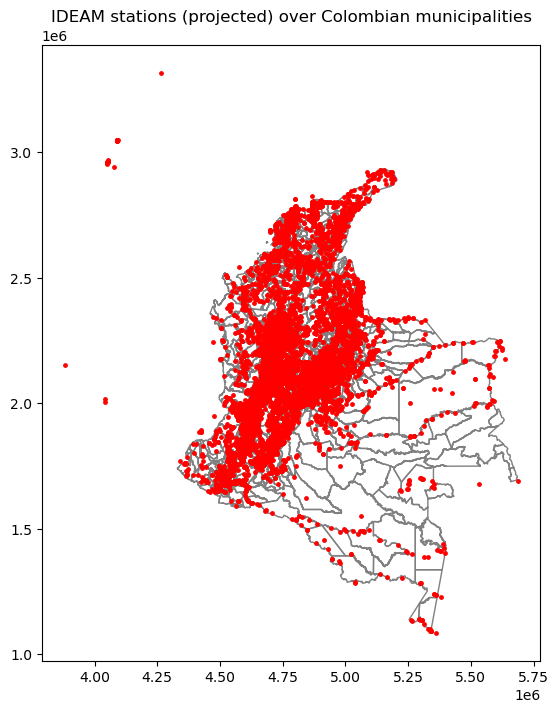

In [25]:

# ── Quick checks ───────────────────────────────────────────────────────────
print("Head of re-projected station GeoDataFrame:")
display(gdf_est.head())
print("gdf_mun columns",gdf_mun.columns)
ax = gdf_mun.plot(color="none", edgecolor="grey", figsize=(8, 8))
gdf_est.plot(ax=ax, color="red", markersize=6)
plt.title("IDEAM stations (projected) over Colombian municipalities")
plt.show()

In [27]:
print(eva["CULTIVO"].unique())
print(eva.columns)

['ACELGA' 'ACHICORIA' 'MALANGA' 'ACHIRA' 'ACHIOTE' 'AGRAZ' 'AGUACATE'
 'AJI' 'AGUAJE' 'AHUYAMA' 'AJO' 'AJONJOLI' 'ALBAHACA' 'ALFALFA'
 'ALCACHOFA' 'ALGARROBO' 'ALGODON' 'AMARANTO' 'ANIS' 'ANON' 'ANTURIO'
 'APIO' 'ARANDANO' 'ARAZA' 'ARRACACHA' 'ARROZ' 'ARVEJA' 'ASAI'
 'ASPARRAGUS' 'ASTROMELIA' 'AVENA' 'BACURI' 'BADEA' 'BANANITO' 'BANANO'
 'BATATA' 'BERENJENA' 'BREVO' 'BORE' 'BOROJO' 'BROCOLI' 'CACAO' 'PLATANO'
 'CADUCIFOLIOS' 'CAFE' 'CAUCHO' 'CAIMO' 'CALABACIN' 'CALABAZA' 'CALENDULA'
 'CANYARANA' 'CAÑA AZUCARERA' 'CAÑA FLECHA' 'CAÑA MIEL' 'CAÑA PANELERA'
 'CARDAMOMO' 'CEBADA' 'CEBOLLA DE BULBO' 'CENTENO' 'CEBOLLA DE RAMA'
 'CEBOLLIN' 'CHACHAFRUTO' 'CHAMBA' 'CHAMPIÑON' 'CHIA' 'CIMARRON'
 'CHIRIMOYA' 'CHOLUPA' 'CIRUELA' 'CHONQUE' 'CHONTADURO' 'CITRICOS'
 'CILANTRO' 'CLAVEL' 'COCCULUS' 'COCO' 'COCONA' 'COL' 'CURUBA' 'COLIFLOR'
 'COPOAZU' 'CORDELINE CINTA' 'COROZO' 'CURCUMA' 'DATIL' 'DURAZNO' 'ENELDO'
 'ESPARRAGO' 'ESPARTO' 'ESPINACA' 'ESTROPAJO' 'EUCALIPTO BABY BLUE'
 'FEIJOA' 'FIQUE' 'FIT

## 4  Spatial operations on vector data

### 4.2.1  Spatial subsetting  
*Spatial subsetting* returns a new layer that contains only the
features with a defined spatial relationship to another layer.

#### Identifying IDEAM stations within Bogotá D.C.

* We first filter gdf_mun by the municipal name containing “BOGOTÁ”  and make an explicit copy to avoid modifying the original GeoDataFrame. The **upper()** method is applied to each string in the Series, converting all characters to uppercase.
Ejemplo: "Bogotá D.C." → "BOGOTÁ D.C.".
Esto se hace para que la búsqueda con contains("BOGOTÁ") no sea sensible a mayúsculas/minúsculas (case-insensitive).
* Then, for each IDEAM station point, .intersects(...) checks whether it lies inside Bogotá’s polygon. The result is a Boolean Series (True if the station is within the polygon, otherwise False). By writing .iloc[0], you extract the first (and in this case, only) Polygon from that GeoSeries.


In [28]:

bogota_muni = gdf_mun[gdf_mun["MPIO_CNMBR"].str.upper().str.contains("BOGOTÁ")].copy()

bta_stations_bool = gdf_est.intersects(bogota_muni.geometry.iloc[0])
bta_stations_bool # Display the boolean dataset

0       False
1       False
2       False
3       False
4       False
        ...  
8968    False
8969    False
8970    False
8971    False
8972    False
Length: 8973, dtype: bool

Finally, we can subset the statios using the obtained Series, resulting in the subset canterbury_height with only those stations that intersect with Bogotá.



In [29]:
bogota_stations = gdf_est[bta_stations_bool]
print(bogota_stations)

          Codigo                                          Nombre  \
92      21206920                   VILLA TERESA - AUT [21206920]   
124     21206960                  IDEAM BOGOTA  - AUT [21206960]   
125     21205012          UNIVERSIDAD NACIONAL  - AUT [21205012]   
303   2120500127           RADIO SONDA BOGOTA - AUT [2120500127]   
318     21206570                     AEROPUERTO CATAM [21206570]   
...          ...                                             ...   
8952  2120000141    COLEGIO VEINTIUN ANGELES - AUT  [2120000099]   
8953  2120000144  COLEGIO ALEMANIA SOLIDARIA - AUT  [2120000100]   
8955  2120000149      COLEGIO RODOLFO LLINAS - AUT  [2120000109]   
8956  2120000150                 GRAN BRETAÑA - AUT [2120000106]   
8957  2120000151                         LA FISCALA [2120000107]   

                Categoria      Estado Departamento    Municipio  \
92    Climática Principal      Activa       Bogotá  Bogota, D.C   
124   Climática Principal      Activa       Bogot

#### Display the stations over the boundaries of Bogota

In [ ]:
ax = bogota_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))
bogota_stations.plot(ax=ax, color="red", markersize=6)
plt.title("IDEAM stations (projected) over Bogota")
plt.show()

#### Display the results in the within the country


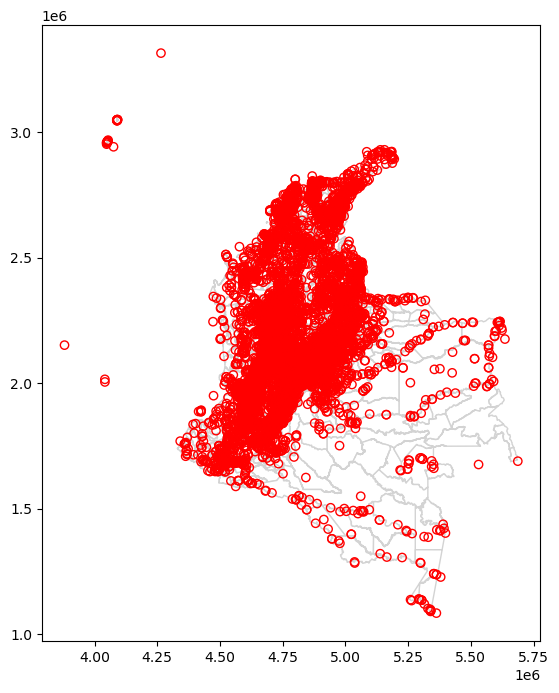

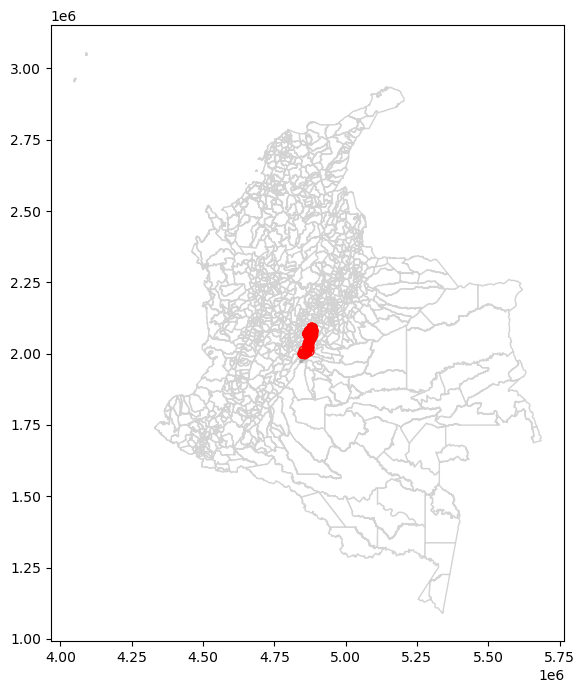

In [30]:
# Original
base = gdf_mun.plot(color='white', edgecolor='lightgrey')
gdf_est.plot(ax=base, color='None', edgecolor='red');
# Subset (intersects)
base = gdf_mun.plot(color='white', edgecolor='lightgrey')
bogota_muni.plot(ax=base, color='lightgrey', edgecolor='darkgrey')
bogota_stations.plot(ax=base, color='None', edgecolor='red');


#### Other topological relations
Other topological relations can be used for spatial subsetting. These include touches, crosses, or within. As an example of another method, we can use .disjoint to obtain all points that do not intersect with Bogotá.

In [32]:
cumaribo_muni = gdf_mun[gdf_mun["MPIO_CNMBR"].str.upper().str.contains("CUMARIBO")].copy()

cumaribo_muni_bool_disj = gdf_est.disjoint(cumaribo_muni.geometry.iloc[0])
cumaribo_muni_bool_disj # Display the boolean dataset
non_cumaribo_stations = gdf_est[cumaribo_muni_bool_disj ]

#### Plotting the results (In a fancier way
Using fig, ax = plt.subplots(...) gives you full control over the figure and axes—especially useful when you need to:

* Specify figure size or resolution (e.g., fig, ax = plt.subplots(figsize=(8, 6))).

* Create multiple maps (subplots) in a single figure (for example, plt.subplots(nrows=1, ncols=2)).

*  Customize titles, legends, annotations, or other elements directly via ax.set_title(), ax.legend(), ax.text(), etc.m

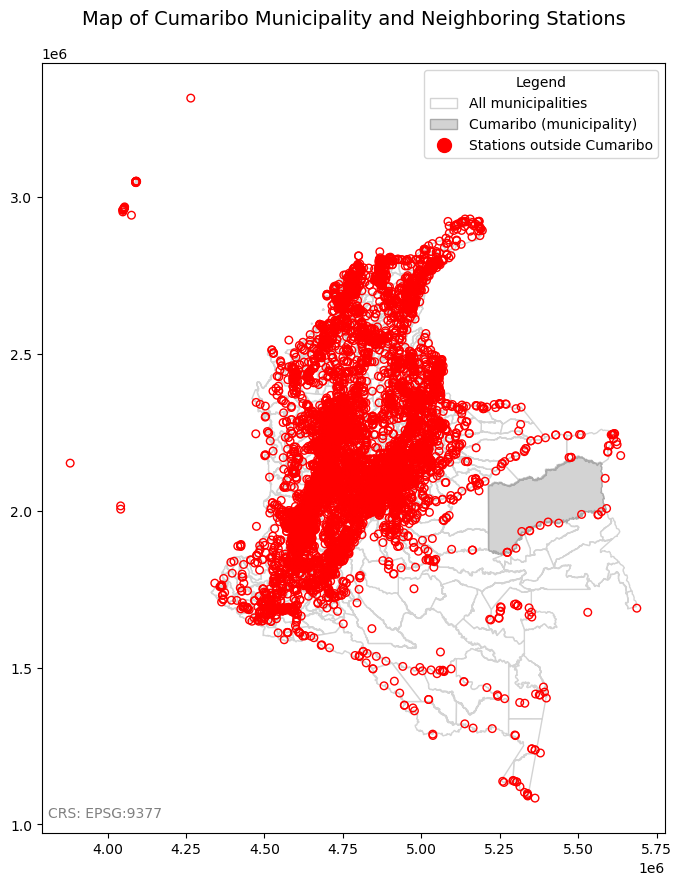

In [33]:
# matplotlib.patches makes available Matplotlib’s “patch” objects, which are simple filled shapes (e.g., rectangles, or polygons) to create a small coloured box or shape.
import matplotlib.patches as mpatches 

# matplotlib.lines provides access to Matplotlib’s “line” objects. E.g. individual markers and line styles. 
# By creating a `Line2D` object with a specific marker and no connecting line (for example, a red circle), you can generate a legend entry that matches how point data are drawn on the map. 
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(10, 10))

# 1. Base layer: all municipalities
gdf_mun.plot(
    ax=ax,
    color='white',
    edgecolor='lightgrey'
)

# 2. Highlight Cumaribo municipality
cumaribo_muni.plot(
    ax=ax,
    color='lightgrey',
    edgecolor='darkgrey'
)

# 3. Plot stations not in Cumaribo
non_cumaribo_stations.plot(
    ax=ax,
    color='None',
    edgecolor='red',
    marker='o',
    markersize=30
)

# 4. Title
ax.set_title(
    "Map of Cumaribo Municipality and Neighboring Stations\n",
    fontsize=14,
    pad=12
)

# 5. Create proxy artists for the legend
#    - Patch for “All municipalities” (white fill, lightgrey edge)
patch_allmun = mpatches.Patch(
    facecolor='white',
    edgecolor='lightgrey',
    label='All municipalities'
)

#    - Patch for “Cumaribo” (lightgrey fill, darkgrey edge)
patch_cumaribo = mpatches.Patch(
    facecolor='lightgrey',
    edgecolor='darkgrey',
    label='Cumaribo (municipality)'
)

#    - Line2D for “Stations outside Cumaribo” (red circle marker)
marker_stations = mlines.Line2D(
    [], [], 
    color='red',   # edgecolor of the marker
    marker='o',
    linestyle='None',
    markersize=10,
    label='Stations outside Cumaribo'
)

# 6. Add the legend using those proxy handles
ax.legend(
    handles=[patch_allmun, patch_cumaribo, marker_stations],
    loc='upper right',
    title='Legend',
    frameon=True
)

# 7. Annotate CRS info in the bottom-left corner
crs_text = f"CRS: {gdf_mun.crs.to_string()}"
ax.text(
    0.01, 0.02, crs_text,
    transform=ax.transAxes,
    fontsize=10,
    color='grey',
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=2)
)

plt.show()


#### 👩‍💻 Now it’s your turn # 1 

For a variation on the previous spatial subsetting exercise, pick a **department** of your choice and:

- Dissolve all its municipality polygons into a single department-level geometry.  
- Subset the IDEAM station GeoDataFrame to keep only those points that **intersect** your department polygon.  

**Deliverables**  
1. A small table listing the station IDs and names you selected.  
2. A map showing your dissolved department boundary (in grey) with the intersecting stations overlaid (in a contrasting colour).  


### 4.2.2  Topological relations

Topological relations describe the spatial relationships between objects. 

*`intersects`*, *`within`*, *`touches`* etc. describe how geometries relate without measuring distance.  
In the cell below, we identify all IDEAM stations located within a 10 km radius of Bogotá’s municipal boundary and then plots them on a map:


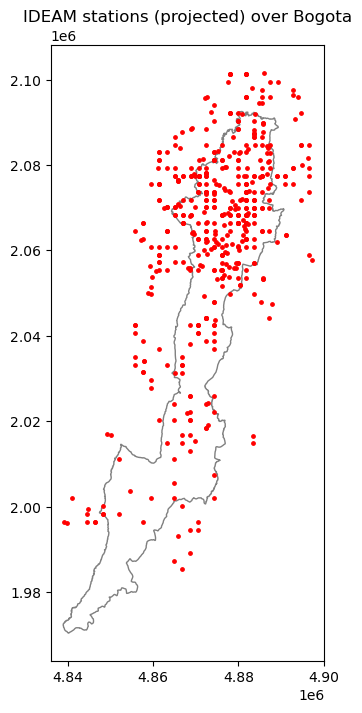

In [34]:
#points.distance(poly.iloc[0]) < 0.2

bta__10km_stations_bool = gdf_est.distance(bogota_muni.geometry.iloc[0])<10000
bta__10km_stations_bool # Display the boolean dataset
bta_10km_stations=gdf_est[bta__10km_stations_bool]

ax = bogota_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))
bta_10km_stations.plot(ax=ax, color="red", markersize=6)
plt.title("IDEAM stations (projected) over Bogota")
plt.show()

#### 👩‍💻 Now it’s your turn # 2. 

Use the Bogotá polygon (`bogota_muni`) to identify all IDEAM stations that lie **outside** the city boundary but within a **20 km** buffer around it. In other words, you need to:

1. Compute the distance from each station point in `gdf_est` to the Bogotá polygon.  
2. List all the stations found and show their altitude
3. Plot the stations in a map


### 4.2.3  Spatial joining

A *spatial join* enriches one spatial layer with the attributes of another, based on their geometric relationships.  
Unlike an attribute join (which matches rows by a common key), a spatial join decides the match through predicates such as **within**, **contains**, **intersects** or via a distance rule (nearest‐neighbour).

Typical uses:

* Assigning administrative names to point observations (point-in-polygon).  
* Counting how many points fall inside each polygon.  
* Adding the attributes of the *nearest* feature when layers do not overlap.  

Below we demonstrate two kinds of spatial join with the Colombian datasets that are already loaded:

* **Point-in-polygon** – tag each IDEAM station with its municipality.  
* **Nearest join** – attach the nearest station ID and distance to every municipality.



In the following chunk, you will perform a **point-in-polygon** spatial join. Each IDEAM station point in `gdf_est` will be assigned the attributes of the municipality polygon from `gdf_mun` that contains it.

The `predicate="within"` argument ensures that only stations fully located inside a polygon will be matched. After the join, the resulting GeoDataFrame includes the original station attributes plus the relevant municipality fields.


#### Overlapping joins

In [35]:
# 1. Spatial join: each station takes the attributes of the municipality it falls in
stations_with_mun = gpd.sjoin(
    gdf_est,                     # left: point layer
    gdf_mun[["MPIO_CCDGO", "MPIO_CNMBR","MPIO_CCDGO", "geometry"]],  # right: polygon layer
    how="left",
    predicate="within"           # point inside polygon
)

# 2. Inspect the result
stations_with_mun[["Codigo", "MPIO_CNMBR", "MPIO_CCDGO"]].head()


,Codigo,MPIO_CNMBR,MPIO_CCDGO,MPIO_CCDGO
0,52057100,IPIALES,00356,00356
1,52055170,CONTADERO,00210,00210
2,52055220,TÚQUERRES,00838,00838
3,44015070,MOCOA,00001,00001
4,48015040,PUERTO NARIÑO,00540,00540


#### Non overlapping joins

Sometimes two geographic datasets do not touch but still have a strong geographic relationship.  When features do **not** overlap, use nearest joins or buffer‑based joins to bridge the gap.  


In this example, we create a 20 km buffer around the Bogotá municipality polygon and then perform a **spatial join** to find all IDEAM stations that fall within that buffer zone.




       Codigo                                  Nombre            Categoria  \
78   21195170                PAQUILO - AUT [21195170]  Climática Principal   
91   21195190                  PASCA - AUT [21195190]    Agrometeorológica   
92   21206920           VILLA TERESA - AUT [21206920]  Climática Principal   
107  21206990              TIBAITATA - AUT [21206990]    Agrometeorológica   
112  21206980  SANTA CRUZ DE SIECHA  - AUT [21206980]    Agrometeorológica   

     Estado  Departamento                Municipio  \
78   Activa  Cundinamarca   Cabrera (Cundinamarca)   
91   Activa  Cundinamarca                    Pasca   
92   Activa        Bogotá              Bogota, D.C   
107  Activa  Cundinamarca  Mosquera (Cundinamarca)   
112  Activa  Cundinamarca                   Guasca   

                      Ubicación  Altitud Fecha_instalacion Fecha_suspension  \
78   (3.99361111, -74.39805556)     2957        2005-07-23              NaN   
91      (4.31011111, -74.31175)     2256        

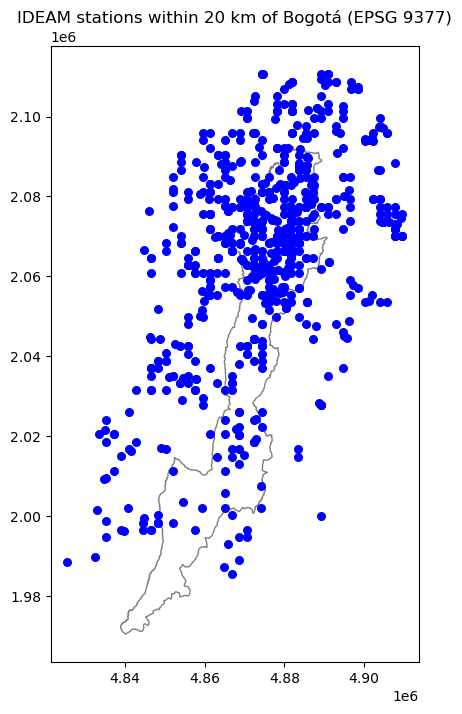

In [36]:
# 1. Create a 20 km buffer around Bogotá
bogota_muni_buffer = bogota_muni.copy()
bogota_muni_buffer["geometry_20km"] = bogota_muni_buffer.geometry.buffer(20000)
bogota_muni_buffer = bogota_muni_buffer.set_geometry("geometry_20km")

# 2. Spatial join – keep only stations that intersect the buffer
bogota_buffer_20k_stations = gpd.sjoin(
    gdf_est,                 # left: station points
    bogota_muni_buffer,     # right: buffer polygons
    how='inner',            # keep only points that intersect the buffer
    predicate='intersects'  # or 'within'
)

# 3. View result
print(bogota_buffer_20k_stations.head())

# 4. Plot Bogotá and the selected stations
ax = bogota_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))
bogota_buffer_20k_stations.plot(ax=ax, color="blue", markersize=30)
plt.title("IDEAM stations within 20 km of Bogotá (EPSG 9377)")
plt.show()


#### 3.2.6 Joining incongruent layers

In many spatial analyses, we work with layers that are **congruent**: for example, municipality polygons fit perfectly within departmental boundaries, or smaller units aggregate neatly into larger ones. In such cases, operations like *spatial aggregation* are straightforward.

However, in many practical cases, layers are **incongruent**:  
- a regular grid of squares may not align perfectly with municipal boundaries;  
- different administrative layers may not share common borders;  
- thematic data may need to be transferred from one set of zones to another.  

When performing **spatial joins between incongruent layers**, simple operations like `sjoin` can tell us whether geometries intersect.  
But to *transfer attributes* meaningfully (for example, population counts or production totals), we need to compute the **area-weighted contribution** of each source polygon to each target polygon (overlay operation + weighting).

This process is called **area-weighted interpolation**:
- for *extensive variables* (e.g. population, production), we sum weighted parts.  
- for *intensive variables* (e.g. population density), we compute weighted averages.

In the following example, we create a synthetic **regular grid** of squares that covers the extent of Colombian municipalities, and show how to perform an area-weighted overlay to assign municipal population (or any other polygon attribute) to the grid.



In [37]:
import numpy as np
import shapely

# Create a regular grid covering Colombia

# Bounds of the municipalities layer
bounds = gdf_mun.total_bounds
xmin, ymin, xmax, ymax = bounds

# Define grid resolution (example: 100 km x 100 km grid → 100_000 m)
res = 100000

# Build grid coordinates
cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax + res)), res))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax + res)), res))
rows.reverse()

# Build polygons for each grid cell
polygons = []
for x in cols:
    for y in rows:
        polygons.append(
            shapely.Polygon([
                (x, y),
                (x + res, y),
                (x + res, y - res),
                (x, y - res)
            ])
        )

# Create grid GeoDataFrame
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=gdf_mun.crs)

# Remove cells that fall outside the total extent (intersect municipalities only)
sel = grid.intersects(shapely.box(*bounds))
grid = grid[sel]

# Add unique ID
grid['id'] = grid.index

grid.head()


,geometry,id
0,"POLYGON ((4047822 3090086, 4147822 3090086, 41...",0
1,"POLYGON ((4047822 2990086, 4147822 2990086, 41...",1
2,"POLYGON ((4047822 2890086, 4147822 2890086, 41...",2
3,"POLYGON ((4047822 2790086, 4147822 2790086, 41...",3
4,"POLYGON ((4047822 2690086, 4147822 2690086, 41...",4


Now we have a **regular grid of squares** covering the extent of Colombia.  

Next, we will perform an **overlay** operation to split the municipality polygons according to the grid cells, and then transfer a polygon attribute (e.g. population or area) to the grid cells.


In [38]:
#  Prepare the municipalities layer: add 'area' attribute

# Calculate polygon area in square metres
gdf_mun['area_m2'] = gdf_mun.area

# Example variable to transfer: let's simulate that each municipality has an attribute 'population'
# For this example only: we'll assign a dummy population proportional to area (you can replace it with real data)
gdf_mun['population'] = gdf_mun['area_m2'] / 1e6  # arbitrary example: 1 person per km²

# View sample
gdf_mun[['MPIO_CNMBR', 'area_m2', 'population']].head()


,MPIO_CNMBR,area_m2,population
0,FLORENCIA,2.546958e+09,2546.958298
1,ALBANIA,4.141007e+08,414.100691
2,BELÉN DE LOS ANDAQUÍES,1.191551e+09,1191.551389
3,EL DONCELLO,1.105515e+09,1105.514836
4,EL PAUJÍL,1.234141e+09,1234.140645


In [39]:
#  Overlay operation: split municipalities by grid cells

mun_grid = gdf_mun.overlay(grid)

# Keep only needed columns
mun_grid = mun_grid[['id', 'area_m2', 'population', 'geometry']]

# Compute the area of each piece (intersection area)
mun_grid['area_sub'] = mun_grid.area

mun_grid.head()


,id,area_m2,population,geometry,area_sub
0,138,2.546958e+09,2546.958298,"POLYGON ((4730891.264 1800687.527, 4730982.048...",8.540306e+07
1,139,2.546958e+09,2546.958298,"POLYGON ((4733986.939 1790054.988, 4733960.326...",2.461555e+09
2,139,4.141007e+08,414.100691,"POLYGON ((4677934.064 1709133.8, 4677934.101 1...",2.824512e+08
3,140,4.141007e+08,414.100691,"POLYGON ((4693057.163 1690081.8, 4693088.62 16...",1.316495e+08
4,139,1.191551e+09,1191.551389,"POLYGON ((4690005.125 1751582.406, 4689993.69 ...",1.190663e+09


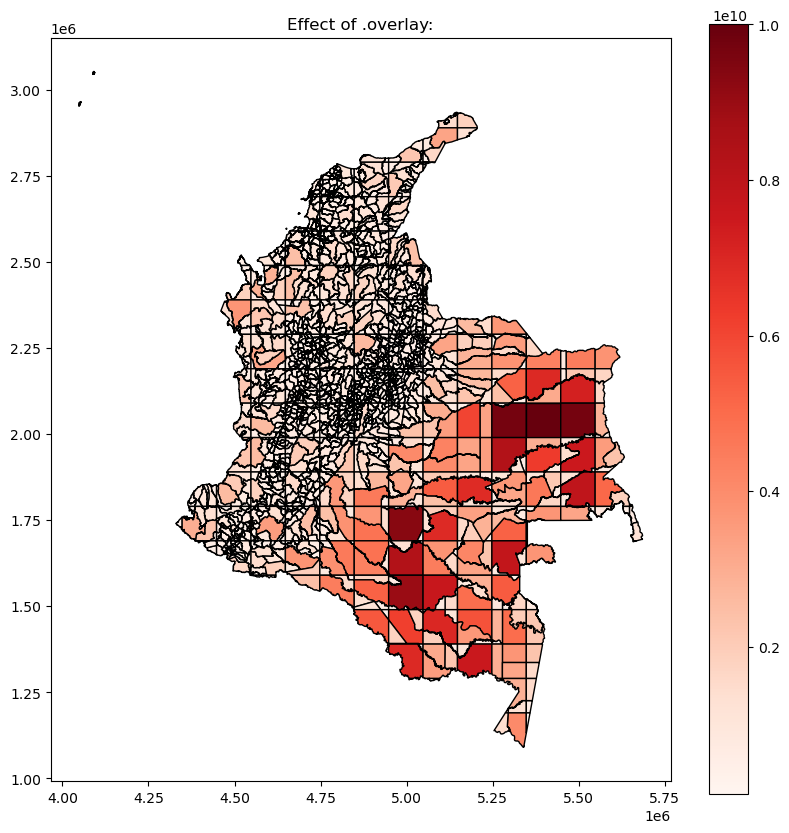

In [40]:
# Plot the result

ax = mun_grid.plot(
    column='area_sub',
    edgecolor='black',
    legend=True,
    cmap='Reds',
    figsize=(10, 10),
    vmin=100000000,
    vmax=10000000000
)

# Title
plt.title("Effect of .overlay:")
plt.show()

At this stage, each grid cell contains **pieces of municipality polygons**.  
But the *Population* field still holds the original full polygon value — we need to adjust it.

Next we compute the **area proportion** and the corrected population per piece.


In [41]:
# Compute area proportion and corrected population per piece

mun_grid['area_prop'] = mun_grid['area_sub'] / mun_grid['area_m2']
mun_grid['population_part'] = mun_grid['population'] * mun_grid['area_prop']

mun_grid[['id', 'area_prop', 'population_part']].head()


,id,area_prop,population_part
0,138,0.033531,85.403059
1,139,0.966469,2461.555239
2,139,0.682083,282.451200
3,140,0.317917,131.649491
4,139,0.999254,1190.663037


Finally, we aggregate the contributions per grid cell:  
**sum the population of all pieces** belonging to each grid cell.


In [42]:
# Aggregate to grid

# Sum the partial populations per grid cell
grid_population = mun_grid.groupby('id')['population_part'].sum().reset_index()

# Join the result back to the grid
grid = pd.merge(grid, grid_population, on='id', how='left')



                                              geometry   id  population_part
213  POLYGON ((5047822 1790086, 5147822 1790086, 51...  223          10000.0
193  POLYGON ((4947822 1790086, 5047822 1790086, 50...  202          10000.0
107  POLYGON ((4547822 2390086, 4647822 2390086, 46...  112          10000.0
272  POLYGON ((5347822 1890086, 5447822 1890086, 54...  285          10000.0
252  POLYGON ((5247822 1890086, 5347822 1890086, 53...  264          10000.0
..                                                 ...  ...              ...
335  POLYGON ((5647822 1590086, 5747822 1590086, 57...  351              NaN
336  POLYGON ((5647822 1490086, 5747822 1490086, 57...  352              NaN
337  POLYGON ((5647822 1390086, 5747822 1390086, 57...  353              NaN
338  POLYGON ((5647822 1290086, 5747822 1290086, 57...  354              NaN
339  POLYGON ((5647822 1190086, 5747822 1190086, 57...  355              NaN

[340 rows x 3 columns]


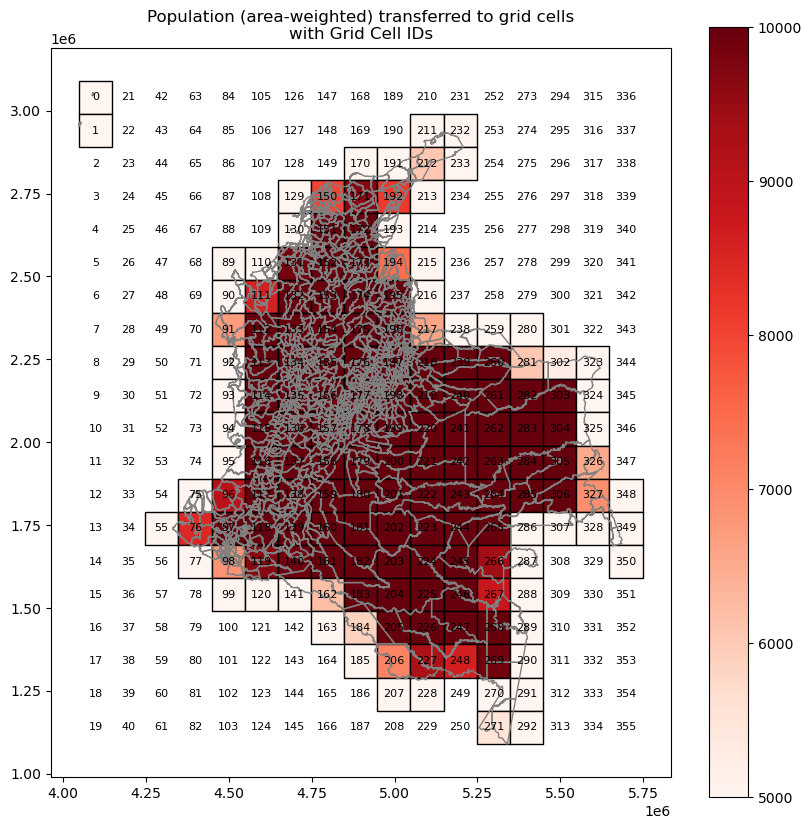

In [43]:
# Plot the result
print(grid.sort_values(by=['population_part'],ascending=False))
ax = grid.plot(
    column='population_part',
    edgecolor='black',
    legend=True,
    cmap='Reds',
    figsize=(10, 10),
    vmin=5000,
    vmax=10000
)

# Overlay the municipality boundaries
gdf_mun.plot(ax=ax, color='none', edgecolor='grey')

# Add ID labels at centroid of each grid cell
for idx, row in grid.iterrows():
    # Compute centroid of the polygon
    centroid = row['geometry'].centroid
    # Draw text label at the centroid coordinates
    ax.text(
        centroid.x, centroid.y, 
        str(row['id']), 
        ha='center', va='center', 
        fontsize=8, color='black'
    )

# Title
plt.title("Population (area-weighted) transferred to grid cells\nwith Grid Cell IDs")
plt.show()

## 5  Geometry operations on vector data

### 5.2.1  Simplification

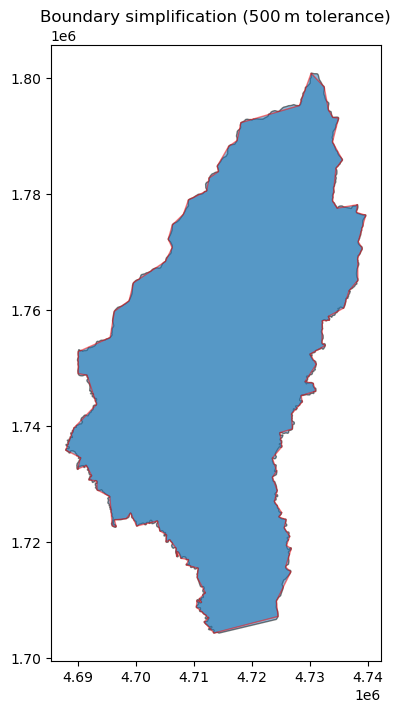

In [44]:
# Simplify a municipality boundary with Douglas–Peucker 500 m tolerance
poly = gdf_mun.iloc[0].geometry
simple = poly.simplify(500)

gpd.GeoSeries({'Original': poly, 'Simplified': simple}).plot(alpha=0.5, edgecolor=['black','red'])
plt.title('Boundary simplification (500 m tolerance)')
plt.show()


### 5.2.2  Centroids

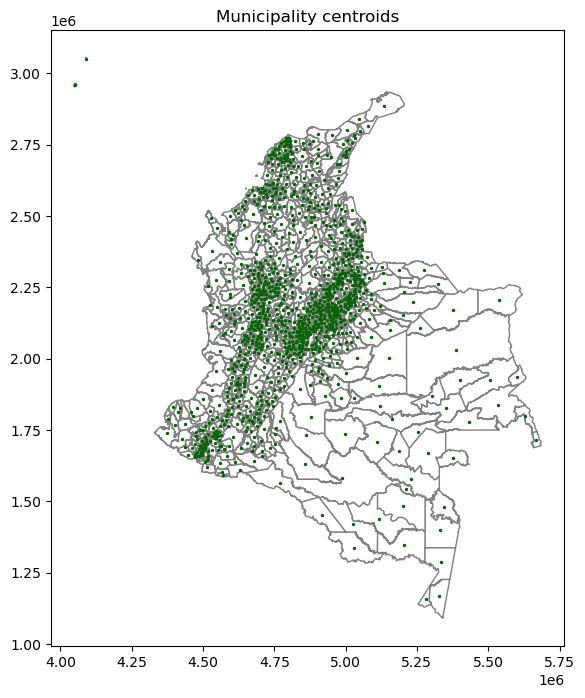

In [45]:
gdf_mun['centroid'] = gdf_mun.centroid
ax = gdf_mun.plot(color='white', edgecolor='grey')
gdf_mun.set_geometry('centroid').plot(ax=ax, color='darkgreen', markersize=2)
plt.title('Municipality centroids')
plt.show()


### 5.2.3 Buffers

A buffer generates a polygon at a specified distance around a geometry.

- For points → a circle.
- For lines → a corridor.
- For polygons → a wider polygon.

**Typical use cases:**

- Identifying all points or features within a given distance.
- Creating impact zones around features.

Example: Create a 10 km buffer around all IDEAM stations.

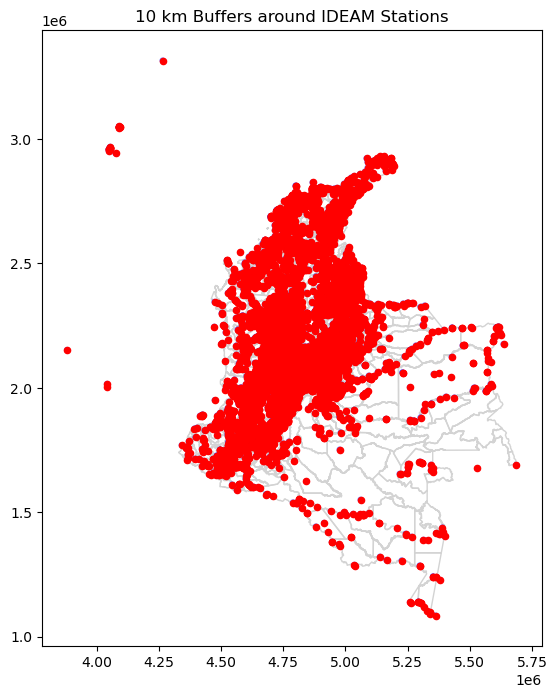

In [46]:
# Create a 10 km buffer around each station
gdf_est['buffer_10km'] = gdf_est.geometry.buffer(10000)

# Visualise one example station buffer
ax = gdf_mun.plot(color='none', edgecolor='lightgrey', figsize=(8, 8))
gpd.GeoSeries(gdf_est['buffer_10km']).plot(ax=ax, facecolor='lightblue', edgecolor='blue', alpha=0.5)
gdf_est.plot(ax=ax, color='red', markersize=20)

plt.title("10 km Buffers around IDEAM Stations")
plt.show()


#### 👩‍💻 Now it’s your turn # 3.
You will now apply what you learned about **buffer creation** using a real-world vector dataset:

👉 Download the **roads vector layer** from INVIAS Open Data Portal:  
[https://inviasopendata-invias.opendata.arcgis.com/](https://inviasopendata-invias.opendata.arcgis.com/)

You can download, for example, the dataset called "**Red Vial Nacional**" or "**Inventario de Vías**".


1. Import the vector layer (e.g. `roads_invias.shp`) into your notebook using `gpd.read_file()`.  
3. Create a **1 km buffer** around all road geometries.  
4. Plot both the **roads** and the **buffer** on a single map (use different colours and transparency).  


### 5.2.4 Geometry unions

A **geometry union** combines multiple geometries into a single one.

- `.union_all` → performs the union over an entire GeoSeries.

**Example: union of all municipalities in the Bogotá Department**


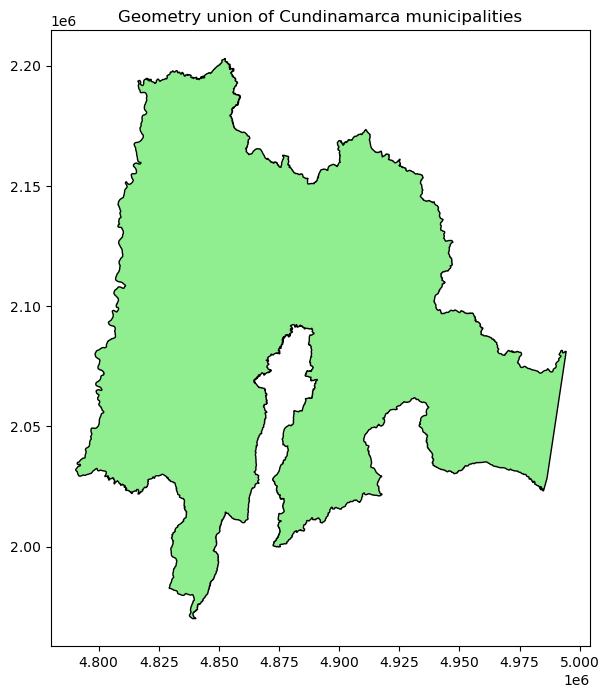

In [47]:
# Union of all Cundinamarca municipalities
cundi_union = gdf_mun[gdf_mun["DPTO_CCDGO"] == "25"].geometry.union_all()

# Plot
gpd.GeoSeries([cundi_union]).plot(color='lightgreen', edgecolor='black', figsize=(8, 8))

plt.title("Geometry union of Cundinamarca municipalities")
plt.show()


#### 👩‍💻 Now it’s your turn # 4. 


Create the **union of all municipalities** that produce Maíz.  
Plot the result and compare it to the individual municipal geometries.


### 5.2.5 Affine transformations

Affine transformations allow us to apply **linear transformations** to geometries:

- **Translation** → moves the geometry in space.
- **Scaling** → enlarges or shrinks the geometry.
- **Rotation** → rotates the geometry around a point.

These operations preserve **parallelism** but can change distances, angles, or shape orientation.

**Affine transformations are useful for:**

- Data visualisation (e.g. shifting or mirroring layers for comparison).
- Geometry manipulation (e.g. scaling for buffers or standardisation).
- Preparing geometries for alignment.

**Example: rotate one municipality by 45 degrees**


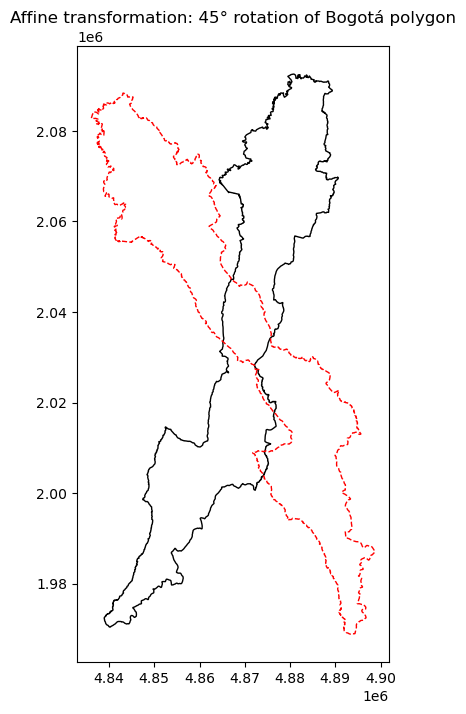

In [48]:
from shapely import affinity

# Select one municipality polygon (Bogotá)
bogota_geom = bogota_muni.geometry.iloc[0]

# Apply a 45 degree rotation around its centroid
bogota_rotated = affinity.rotate(bogota_geom, 45, origin='centroid')

# Plot original and rotated polygon
ax = gpd.GeoSeries([bogota_geom]).plot(color='none', edgecolor='black', figsize=(8, 8), label='Original')
gpd.GeoSeries([bogota_rotated]).plot(ax=ax, color='none', edgecolor='red', linestyle='--', label='Rotated')

plt.title("Affine transformation: 45° rotation of Bogotá polygon")
plt.show()


#### 👩‍💻 Now it’s your turn # 5. 

Select a municipality of your choice and:

1. Apply a **scaling** transformation to enlarge it by 1.5x in X and 0.8x in Y.
2. Plot the original and transformed polygon for comparison.


### 5.2.6 Pairwise geometry-generating operations

You can generate **new geometries** by computing operations between two geometries:

- `.union()` → combines both geometries into one.
- `.intersection()` → keeps only the overlapping part.
- `.difference()` → subtracts one geometry from another.

**Example: intersection between Bogotá buffer and Cundinamarca**

Let’s see which part of the Bogotá 20 km buffer overlaps Cundinamarca.


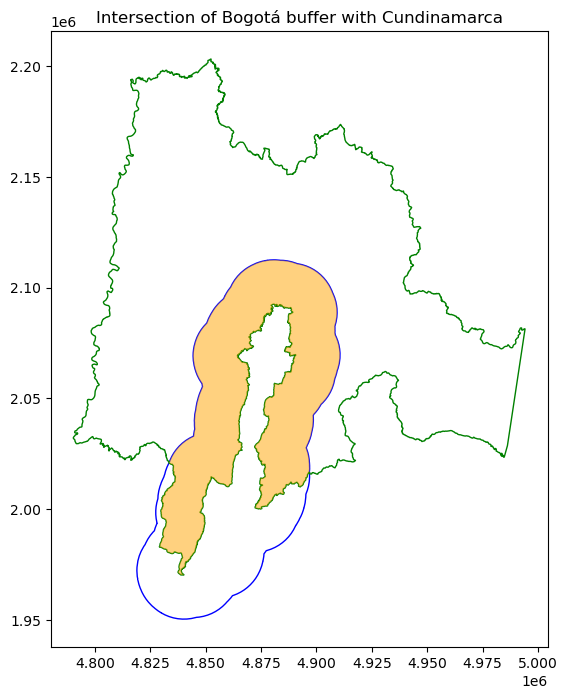

In [49]:
# Cundinamarca polygon
cundi_geom = gdf_mun[gdf_mun["DPTO_CCDGO"] == "25"].dissolve().geometry.iloc[0]

# 20 km buffer around Bogotá
bogota_20km_buffer = bogota_geom.buffer(20000)

# Intersection of buffer and Cundinamarca
buffer_cundi_intersection = bogota_20km_buffer.intersection(cundi_geom)

# Plot result
ax = gpd.GeoSeries([bogota_20km_buffer]).plot(color='none', edgecolor='blue', figsize=(8, 8), label='Bogotá buffer')
gpd.GeoSeries([cundi_geom]).plot(ax=ax, color='none', edgecolor='green', label='Cundinamarca')
gpd.GeoSeries([buffer_cundi_intersection]).plot(ax=ax, color='orange', alpha=0.5, label='Intersection')

plt.title("Intersection of Bogotá buffer with Cundinamarca")
plt.show()


### 5.2.7  Subsetting and Clipping

| Subsetting            | Clipping            |
|-----------------------|---------------------|
| Keeps **whole geometries** based on a predicate (e.g. intersects, within). | Cuts geometries to the boundary of another geometry. |
| Results in a subset of original features. | Results in new geometries. |
| Faster, no geometry modification. | Geometries are altered and may become smaller parts. |

**Example of clipping:**  
We clip the station buffers using the Bogotá polygon.


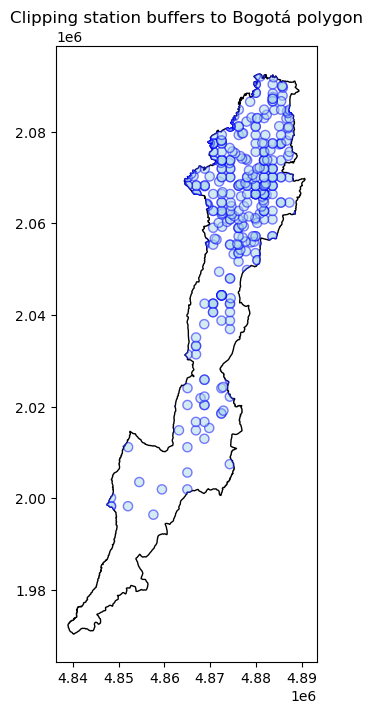

In [50]:
# Clip 10 km station buffers with Bogotá boundary

# First select station buffers intersecting Bogotá
station_buffers = gdf_est.copy()
station_buffers['buffer_5km'] = station_buffers.geometry.buffer(1000)

# Clip buffers with Bogotá polygon
station_buffers_clipped = gpd.clip(station_buffers.set_geometry('buffer_5km'), bogota_geom)

# Plot
ax = gpd.GeoSeries([bogota_geom]).plot(color='none', edgecolor='black', figsize=(8, 8), label='Bogotá')
station_buffers_clipped.plot(ax=ax, facecolor='lightblue', edgecolor='blue', alpha=0.5)

plt.title("Clipping station buffers to Bogotá polygon")
plt.show()


## 6  Project guidelines

Your goal is to:

1. **Select the single most suitable municipality** based on a well-structured, reproducible spatial analysis.
2. **Within the selected municipality**, identify and map the **best local area** (polygon) where the project (crop, school, hospital, other facility) should be implemented.

Your final output will therefore include **two levels of analysis**:

- Level 1 — **Municipality ranking** based on multi-criteria analysis.
- Level 2 — **Intra-municipality spatial analysis** to identify the best location within the selected municipality.


### 6.1  Data preparation & CRS

- All spatial layers must be **re-projected to EPSG 9377**.
- Document any cleaning, pre-processing or CRS transformations you perform.



### 6.2  Core analysis steps — Level 1: Municipality selection

Your municipality-level analysis should:

- Select an appropriate **subset of municipalities** relevant to your project (e.g. by department, region, attribute value, or spatial location).
- Compute one or more **spatial buffers** where appropriate (e.g. buffers around roads to assess accessibility).
- Use **topological relations** (`intersects`, `within`, `contains`, `touches`) as needed to evaluate relationships between layers.
- Perform at least one type of **spatial join**.
- Include at least one example of **joining incongruent layers**:
    - For example: compute **road density per municipality** by performing an *overlay* between the road network and municipality polygons (e.g. length of roads per km² of municipality area).
    - Other options: interpolate EVA production onto a grid and aggregate to municipalities.
- Apply at least one **geometry operation** to refine your analysis:
    - **Affine transformation** (rotate, scale, translate — can be used for illustration or testing).
    - **Intersection**, **union**, or **difference** of polygons to model or visualise candidate areas.
    - **Clipping** vs **sub-setting** should be demonstrated in at least one part of your workflow.

---

### 6.3  Multi-criteria analysis — Level 1

You must define a set of at least **four weighted criteria** to rank the municipalities.

**One of these criteria must incorporate the availability of climate monitoring infrastructure**, for example:

- **Number of IDEAM stations per municipality** (from point-in-polygon spatial join — mandatory).
- OR **Mean distance to nearest IDEAM station**.

Other possible criteria include:

| Possible criterion | Source / example |
|--------------------|------------------|
| **Road density per municipality** | Road length per km² of municipality (overlay roads ↔ municipalities) |
| **EVA production of crop X** | EVA data (production per municipality, normalised by area or population) |
| **Population served** | Population data or interpolated grid |
| **Proximity to main roads** | % of municipality area within 1 km / 5 km of roads (buffer + overlay) |
| **Risk criteria** | Presence/absence of flood zones or other risk layers (optional if used) |


### 6.4  Core analysis steps — Level 2: Best location within selected municipality

Once you have selected your **best municipality**, you will conduct a **second level of spatial analysis** to identify the **best local area within that municipality**.

Your intra-municipality analysis must:

- Subset your layers to the selected municipality.
- Use **joining incongruent layers** where appropriate (e.g. road density per grid cell).
- Perform a **fine-grained spatial analysis** using a regular grid or by dividing the municipality into zones.
- Define at least **three local spatial criteria** to evaluate the best area for the project.

Examples of local criteria:

| Possible local criterion | Example |
|--------------------------|---------|
| **Distance to roads** | Prefer areas close to roads (1 km buffer) |
| **Proximity to stations** | Prefer areas near climate stations |
| **Land availability** | Avoid built-up areas, protected areas (if data available) |
| **Crop suitability** | Based on EVA or other agronomic factors |

- The output should include:
    - The selected **best area** (polygon) where the project should be implemented (≤ 5 km²).


### 6.5  Final output

Your final output must include:

- **Best municipality** selected based on Level 1 analysis.
- **Best area** within the selected municipality.
- One map showing key **intermediate layers** (e.g. road buffers, stations, road density).


## 6.6  Assessment rubric (20 marks)

| Criterion | Excellent **5** | Good **4** | Satisfactory **3** | Needs improvement 1–2 |
|-----------|-----------------|------------|--------------------|-----------------------|
| **Data preparation & CRS** | All mandatory layers plus EVA **and** ≥ 1 extra dataset re-projected and fully documented | Minor CRS issues, no impact | CRS corrected but documentation sparse | CRS incorrect or undocumented |
| **Spatial operations** | All required operations used correctly | One minor misuse/omission | At least three operations correct | Few operations or conceptual errors |
| **Multi-criteria analysis (municipality + intra-municipality)** | ≥ 4 criteria for Level 1 (municipality ranking), incl. one variable from joining incongruent layers and the IDEAM monitoring criterion; **AND** ≥ 3 local criteria for Level 2 (site selection within the municipality); weights justified and results reproducible | Criteria for both levels clear; minor weighting issues; results reproducible | Basic criteria applied for both levels; ranking reproducible | Lacks rationale or reproducibility in one or both levels |
| **Visualisation & cartography** | Clear, well-styled maps; legends, labels, colour stretch; extra thematic map | Maps clear; minor style issues | Maps legible but cluttered | Maps confusing or missing |
| **Notebook structure and documentation** | Notebook is clearly structured with informative section titles; Markdown cells explain each step; code is well commented and easy to follow | Notebook structure mostly clear; minor gaps in Markdown or comments | Basic structure present but limited explanation or commenting | Poorly documented; difficult to follow; little or no explanation of workflow |

**Bonus:** Up to **+1 bonus mark** for integrating two or more additional external datasets beyond those supplied.



## 6  Submission details

- **Deadline:** 23:59 (Colombia time) on **june 16th 2025**.
- **Late penalty:** **–0.5 mark per calendar day** after the deadline.
- Push notebook to GitHub and submit the link




---  
© 2025 Universidad Nacional de Colombia – Facultad de Ciencias Agrarias 
Liliana Castillo Villamor
This notebook is released under a Creative Commons Attribution 4.0 licence.  
